In [1902]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
import seaborn

In [1752]:
constraints = [
    (5, 5),  # no more than 5 wdraws in  5 epochs
]
T_MAX = max(constraints, key=lambda x:x[1])[1]
T_MAX

5

In [1753]:
class Pending:
    def __init__(self, value, reqTime):
        self.value = value
        self.reqTime = reqTime
    
    def __str__(self):
        return 'p: value={}, reqTime={}'.format(self.value, self.reqTime)

class Processed:
    def __init__(self, value, procTime):
        self.value = value
        self.procTime = procTime
    
    def __str__(self):
        return 'proc: value={}, procTime={}'.format(self.value, self.procTime)

In [1792]:
def MINSLACK(n=None, mu=None, dist=None):
    pending = []
    history = []
    results = []
    for curTime in range(n):
        # Expire oldest withdrawals
        historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
        history = historyNew

        slacks = []
        for c in constraints:
            delta_i, t_i = c
            relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
            slack_i = delta_i - len(relevant_history)
            slacks.append(slack_i)
        minSlack = min(slacks)

        # Process withdrawals
        withdrawals = pending[:minSlack]
        history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
        pending = pending[minSlack:]

        if curTime > 1000:
            newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
            results.extend(newResults)

        # Add new pendings
        # numWdraws = poisson.rvs(mu=mu)
        numWdraws = np.random.choice([0,1,5], p=[0.5, 0.4, 0.1])
        newValues = dist(numWdraws)
        newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
        pending.extend(newPending)
    results = np.asarray(results)
    return results

In [1793]:
def MINSLACK_PRIO(n=None, mu=None, dist=None):
    pending = []
    history = []
    results = []
    for curTime in range(n):
        # Expire oldest withdrawals
        historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
        history = historyNew

        slacks = []
        for c in constraints:
            delta_i, t_i = c
            relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
            slack_i = delta_i - len(relevant_history)
            slacks.append(slack_i)
        minSlack = min(slacks)

        # Process withdrawals
        withdrawals = pending[:minSlack]
        history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
        pending = pending[minSlack:]

        if curTime > 1000:
            newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
            results.extend(newResults)

        # Add new pendings
        # numWdraws = poisson.rvs(mu=mu)
        numWdraws = np.random.choice([0,1,5], p=[0.5, 0.4, 0.1])
        newValues = dist(numWdraws)
        newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
        pending.extend(newPending)

        pending.sort(reverse=True, key=lambda x:x.value)

    results = np.asarray(results)
    return results

In [1794]:
def MINSLACK_PROP(n=None, mu=None, alpha=None, dist=None):
    pending = []
    history = []
    results = []
    for curTime in range(n):
        # Expire oldest withdrawals
        historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
        history = historyNew

        slacks = []
        for c in constraints:
            delta_i, t_i = c
            relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
            slack_i = delta_i - len(relevant_history)
            slacks.append(slack_i)
        minSlack = min(slacks)

        # PROP
        # minSlackProp = int(minSlack * alpha)
        minSlackProp = round(minSlack * alpha)

        # Process withdrawals
        withdrawals = pending[:minSlackProp]
        history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
        pending = pending[minSlackProp:]

        if curTime > 1000:
            newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
            results.extend(newResults)

        # Add new pendings
        # numWdraws = poisson.rvs(mu=mu)
        numWdraws = np.random.choice([0,1,5], p=[0.5, 0.4, 0.1])
        newValues = dist(numWdraws)
        newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
        pending.extend(newPending)

        pending.sort(reverse=True, key=lambda x:x.value)

    results = np.asarray(results)
    return results

In [1795]:
sample = pareto.rvs(b=1.5, scale=4, size=100)
# sample = expon.rvs(scale=10, size=100)
sample.min(), sample.mean(), sample.max()

(4.022057568955374, 13.505315253824488, 179.70725562192308)

In [1796]:
def exponentialRV(numWdraws):
    return expon.rvs(scale=1, size=numWdraws)

def uniformRV(numWdraws):
    return uniform.rvs(0, 1, size=numWdraws)

def paretoRV(numWdraws):
    return pareto.rvs(b=2, scale=5, size=numWdraws)

In [1797]:
msstan = []
msprio = []
msprop = []
for _ in range(10):
    n = 10000
    mu = 0.75
    resMSStan = MINSLACK(n=n, mu=mu, dist=paretoRV)
    resMSPrio = MINSLACK_PRIO(n=n, mu=mu, dist=paretoRV)
    resMSProp = MINSLACK_PROP(n=n, mu=mu, alpha=0.9, dist=paretoRV)
    print('ms={:0.5f},prio={:0.5f},prop={:0.5f}'.format(
          np.mean(resMSStan[:,0] * resMSStan[:,1]),
          np.mean(resMSPrio[:,0] * resMSPrio[:,1]), 
          np.mean(resMSProp[:,0] * resMSProp[:,1])))
    msstan.append(np.mean(resMSStan[:,0] * resMSStan[:,1]))
    msprio.append(np.mean(resMSPrio[:,0] * resMSPrio[:,1]))
    msprop.append(np.mean(resMSProp[:,0] * resMSProp[:,1]))
msstan = np.asarray(msstan)
msprio = np.asarray(msprio)
msprop = np.asarray(msprop)

print('---')
print('ms-stan mean={:0.3f} \pm {:0.3f}'.format(msstan.mean(), msstan.std()))
print('ms-prio mean={:0.3f} \pm {:0.3f}'.format(msprio.mean(), msprio.std()))
print('ms-prop mean={:0.3f} \pm {:0.3f}'.format(msprop.mean(), msprop.std()))

ms=83.42927,prio=70.08013,prop=59.29258
ms=139.34167,prio=73.16369,prop=67.10285
ms=130.26206,prio=63.15345,prop=56.78325
ms=88.73674,prio=63.39331,prop=61.71974
ms=99.92107,prio=68.16932,prop=56.72634
ms=189.92315,prio=73.99101,prop=81.27378
ms=135.78036,prio=73.52582,prop=47.51607
ms=137.34176,prio=67.25551,prop=55.37384
ms=71.02187,prio=63.40547,prop=58.92578
ms=97.00155,prio=93.70925,prop=68.70996
---
ms-stan mean=117.276 \pm 33.897
ms-prio mean=70.985 \pm 8.577
ms-prop mean=61.342 \pm 8.740


In [1742]:
alpha = 0.9
[round(x*alpha) for x in np.arange(0, 6)]

[0, 1, 2, 3, 4, 4]

In [1918]:
def CONSTANTSLACK(n=None, mu=None, dist=None):
    pending = []
    history = []
    results = []
    for curTime in range(n):
        # Expire oldest withdrawals
        historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
        history = historyNew

        minSlack = 1

        # Process withdrawals
        withdrawals = pending[:minSlack]
        history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
        pending = pending[minSlack:]

        if curTime > 1000:
            newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
            results.extend(newResults)

        # Add new pendings
        # numWdraws = poisson.rvs(mu=mu)
        numWdraws = np.random.choice([0,1,5], p=[0.5, 0.4, 0.1])
        newValues = dist(numWdraws)
        newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
        pending.extend(newPending)
    results = np.asarray(results)
    return results

In [ ]:
def exponentialRV(numWdraws):
    return expon.rvs(scale=1, size=numWdraws)

def uniformRV(numWdraws):
    return uniform.rvs(0, 1, size=numWdraws)

def paretoRV(numWdraws):
    return pareto.rvs(b=2, scale=5, size=numWdraws)

In [1926]:
mscons = []
for _ in range(10):
    n = 10000
    mu = 0.75
    resMSCons = CONSTANTSLACK(n=n, mu=mu, dist=exponentialRV)
    print('cons={:0.5f}'.format(
          np.mean(resMSCons[:,0] * resMSCons[:,1])))
    mscons.append(np.mean(resMSCons[:,0] * resMSCons[:,1]))
mscons = np.asarray(mscons)

print('---')
print('ms-cons mean={:0.3f} \pm {:0.3f}'.format(mscons.mean(), mscons.std()))

cons=15.81574
cons=9.58470
cons=11.34103
cons=10.68074
cons=12.28318
cons=10.36500
cons=10.46045
cons=16.11574
cons=12.66375
cons=13.17580
---
ms-cons mean=12.249 \pm 2.141


In [1798]:
constraints = [
    (5, 5),  # no more than 5 wdraws in  5 epochs
]
T_MAX = max(constraints, key=lambda x:x[1])[1]
T_MAX

5

In [1799]:
def MINSLACK(n=None, mu=None, dist=None):
    pending = []
    history = []
    results = []
    for curTime in range(n):
        # Expire oldest withdrawals
        historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
        history = historyNew

        slacks = []
        for c in constraints:
            delta_i, t_i = c
            relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
            slack_i = delta_i - len(relevant_history)
            slacks.append(slack_i)
        minSlack = min(slacks)

        # Process withdrawals
        withdrawals = pending[:minSlack]
        history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
        pending = pending[minSlack:]

        if curTime > 1000:
            newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
            results.extend(newResults)

        # Add new pendings
        numWdraws = poisson.rvs(mu=mu)
        # numWdraws = np.random.choice([0,1,5], p=[0.5, 0.4, 0.1])
        newValues = dist(numWdraws)
        newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
        pending.extend(newPending)
    results = np.asarray(results)
    return results

def MINSLACK_PRIO(n=None, mu=None, dist=None):
    pending = []
    history = []
    results = []
    for curTime in range(n):
        # Expire oldest withdrawals
        historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
        history = historyNew

        slacks = []
        for c in constraints:
            delta_i, t_i = c
            relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
            slack_i = delta_i - len(relevant_history)
            slacks.append(slack_i)
        minSlack = min(slacks)

        # Process withdrawals
        withdrawals = pending[:minSlack]
        history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
        pending = pending[minSlack:]

        if curTime > 1000:
            newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
            results.extend(newResults)

        # Add new pendings
        numWdraws = poisson.rvs(mu=mu)
        #numWdraws = np.random.choice([0,1,5], p=[0.5, 0.4, 0.1])
        newValues = dist(numWdraws)
        newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
        pending.extend(newPending)

        pending.sort(reverse=True, key=lambda x:x.value)

    results = np.asarray(results)
    return results

In [ ]:
def exponentialRV(numWdraws):
    return expon.rvs(scale=1, size=numWdraws)

def uniformRV(numWdraws):
    return uniform.rvs(0, 1, size=numWdraws)

In [1851]:
mu = 0.9
resMSStan = MINSLACK(n=10000, mu=mu, dist=uniformRV)
resMSPrio = MINSLACK_PRIO(n=10000, mu=mu, dist=uniformRV)

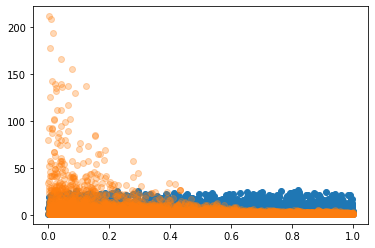

In [1856]:
plt.scatter(resMSStan[:,0], resMSStan[:,1])
plt.scatter(resMSPrio[:,0], resMSPrio[:,1], alpha=0.3)

In [1858]:
dfStan = pd.DataFrame({"vs" : resMSStan[:,0], "times": resMSStan[:,1]})
bins = np.arange(0, 1.01, 0.05)
dfStan["buckets"] = pd.cut(dfStan.vs, bins)
dfStan.head()

,vs,times,buckets
0,0.604094,1.0,"(0.6, 0.65]"
1,0.716907,1.0,"(0.7, 0.75]"
2,0.251302,1.0,"(0.25, 0.3]"
3,0.595809,2.0,"(0.55, 0.6]"
4,0.193386,3.0,"(0.15, 0.2]"


In [1859]:
dfPrio = pd.DataFrame({"vs" : resMSPrio[:,0], "times": resMSPrio[:,1]})
bins = np.arange(0, 1.01, 0.05)
dfPrio["buckets"] = pd.cut(dfPrio.vs, bins)
dfPrio.head()

,vs,times,buckets
0,0.583102,1.0,"(0.55, 0.6]"
1,0.215920,5.0,"(0.2, 0.25]"
2,0.362282,1.0,"(0.35, 0.4]"
3,0.395974,1.0,"(0.35, 0.4]"
4,0.213073,1.0,"(0.2, 0.25]"


In [1860]:
intervals = sorted(list(set(dfStan.buckets.values)))

In [1864]:
violinLocs = []
stanViolins = []
prioViolins = []
for i in intervals:
    violinLocs.append(i.mid)
    stanViolins.append(dfStan[dfStan.buckets == i].times.values)
    prioViolins.append(dfPrio[dfPrio.buckets == i].times.values)

<AxesSubplot:>

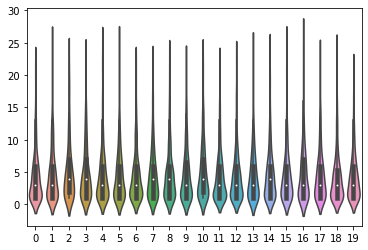

In [1887]:
seaborn.violinplot(data=stanViolins, ax=ax)

In [1892]:
violinDf = pd.DataFrame({"locs": violinLocs, "stan": stanViolins, "prio": prioViolins})
violinDf.head()

,locs,stan,prio
0,0.025,"[5.0, 6.0, 12.0, 9.0, 4.0, 4.0, 5.0, 10.0, 12....","[1.0, 4.0, 5.0, 1.0, 4.0, 1.0, 1.0, 1.0, 4.0, ..."
1,0.075,"[4.0, 7.0, 11.0, 10.0, 8.0, 3.0, 6.0, 11.0, 12...","[1.0, 4.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 4.0, ..."
2,0.125,"[1.0, 1.0, 6.0, 3.0, 6.0, 8.0, 2.0, 2.0, 1.0, ...","[1.0, 5.0, 5.0, 1.0, 1.0, 5.0, 10.0, 4.0, 1.0,..."
3,0.175,"[3.0, 7.0, 10.0, 10.0, 10.0, 9.0, 1.0, 1.0, 6....","[1.0, 1.0, 1.0, 1.0, 1.0, 13.0, 1.0, 4.0, 2.0,..."
4,0.225,"[1.0, 1.0, 6.0, 11.0, 8.0, 9.0, 11.0, 6.0, 7.0...","[5.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."


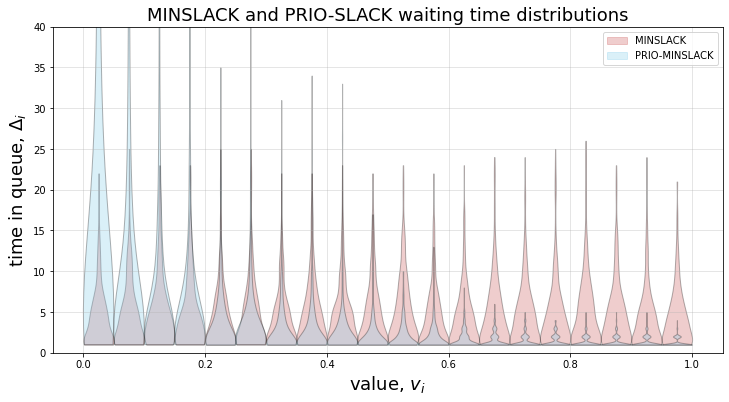

In [1930]:
f, ax = plt.subplots(figsize=(12,6))

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))


vi1 = ax.violinplot(stanViolins, positions=violinLocs, widths=0.05, showextrema=False)

for pc in vi1['bodies']:
    pc.set_facecolor('indianred')
    pc.set_edgecolor('black')

add_label(vi1, "MINSLACK")

vi2 = ax.violinplot(prioViolins, positions=violinLocs, widths=0.05, showextrema=False)

for pc in vi2['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_edgecolor('black')

add_label(vi2, "PRIO-MINSLACK")

ax.set_ylim(0, 40)
ax.grid(alpha=0.4)

ax.set_xlabel('value, $v_i$', size=18)
ax.set_ylabel('time in queue, $\Delta_i$', size=18)
ax.set_title('MINSLACK and PRIO-SLACK waiting time distributions', size=18)

plt.legend(*zip(*labels), loc=1)
plt.savefig('test.png')
plt.show()

{'bodies': [<matplotlib.collections.PolyCollection at 0x1305bfa30>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1305bf8b0>,
 'cmins': <matplotlib.collections.LineCollection at 0x1305bfeb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x12fc421f0>}

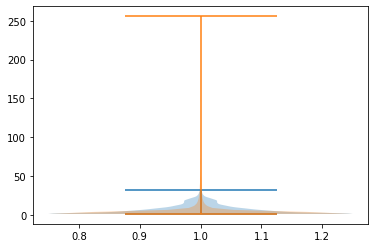

In [1809]:
plt.violinplot(resMSStan[:,1])
plt.violinplot(resMSPrio[:,1])


In [1806]:
np.mean(resMSStan[:,0] * resMSStan[:,1]), np.mean(resMSPrio[:,0] * resMSPrio[:,1])

(3.2031633055034425, 1.0823271014608233)

In [ ]:
f, ax = plt.subplots(figsize=(9,6))

df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()

ax.plot(results[:,0], results[:,1], 
        linestyle="none", marker='.', color='salmon', alpha=0.5, label='all withdrawals')
ax.plot([b.left for b in reduced['buckets'].values], reduced['avgs'],
        linestyle="none", marker='o', color='black', alpha=1, label='bucketized average')

ax.set_xlabel('value', size=14)
ax.set_ylabel('time in queue', size=14)
ax.legend()
plt.show()

In [378]:
# MINSLACK
pending = []
history = []
results = []
for curTime in range(10000):
    # Expire oldest withdrawals
    historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
    history = historyNew

    slacks = []
    for c in constraints:
        delta_i, t_i = c
        relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
        slack_i = delta_i - len(relevant_history)
        slacks.append(slack_i)
    minSlack = min(slacks)
    
    # Process withdrawals
    withdrawals = pending[:minSlack]
    history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
    pending = pending[minSlack:]
    
    newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
    results.extend(newResults)

    # Add new pendings
    numWdraws = poisson.rvs(mu=1.6)
    newValues = uniform.rvs(0, 1, size=numWdraws)
    newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
    pending.extend(newPending)
results = np.asarray(results)
np.mean(results[:,0] * results[:,1])

0.6881303695290789

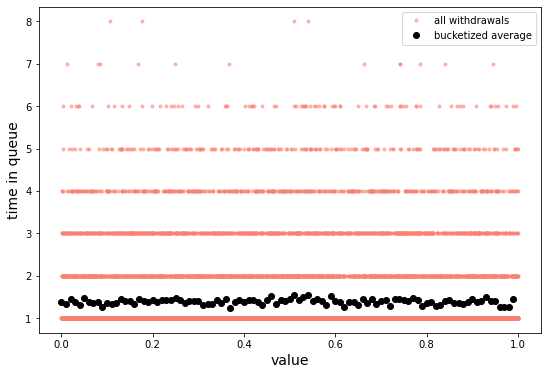

In [379]:
f, ax = plt.subplots(figsize=(9,6))

df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()

ax.plot(results[:,0], results[:,1], 
        linestyle="none", marker='.', color='salmon', alpha=0.5, label='all withdrawals')
ax.plot([b.left for b in reduced['buckets'].values], reduced['avgs'],
        linestyle="none", marker='o', color='black', alpha=1, label='bucketized average')

ax.set_xlabel('value', size=14)
ax.set_ylabel('time in queue', size=14)
ax.legend()
plt.show()

In [380]:
# MINSLACK-PRIO
pending = []
history = []
results = []
for curTime in range(10000):
    # Expire oldest withdrawals
    historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
    history = historyNew

    slacks = []
    for c in constraints:
        delta_i, t_i = c
        relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
        slack_i = delta_i - len(relevant_history)
        slacks.append(slack_i)
    minSlack = min(slacks)
    
    # Process withdrawals
    withdrawals = pending[:minSlack]
    history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
    pending = pending[minSlack:]
    
    newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
    results.extend(newResults)

    # Add new pendings
    numWdraws = poisson.rvs(mu=1.6)
    newValues = uniform.rvs(0, 1, size=numWdraws)
    newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
    pending.extend(newPending)
    
    pending.sort(reverse=True, key=lambda x:x.value)

    
results = np.asarray(results)
np.mean(results[:,0] * results[:,1])

0.5929368317450942

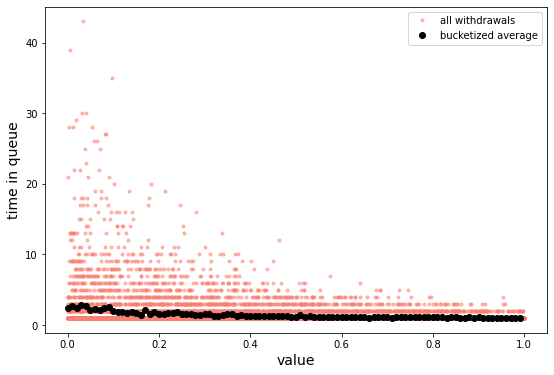

In [381]:
f, ax = plt.subplots(figsize=(9,6))

df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()

ax.plot(results[:,0], results[:,1], 
        linestyle="none", marker='.', color='salmon', alpha=0.5, label='all withdrawals')
ax.plot([b.left for b in reduced['buckets'].values], reduced['avgs'],
        linestyle="none", marker='o', color='black', alpha=1, label='bucketized average')

ax.set_xlabel('value', size=14)
ax.set_ylabel('time in queue', size=14)
ax.legend()
plt.show()

In [382]:
# MINSLACK-PROP
pending = []
history = []
results = []
alpha = 0.5
for curTime in range(10000):
    # Expire oldest withdrawals
    historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
    history = historyNew

    slacks = []
    for c in constraints:
        delta_i, t_i = c
        relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
        slack_i = delta_i - len(relevant_history)
        slacks.append(slack_i)
    minSlack = min(slacks)
    
    # PROP
    minSlackProp = int(np.floor(minSlack * alpha))
    # Process withdrawals
    withdrawals = pending[:minSlackProp]
    history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
    pending = pending[minSlackProp:]
    
    newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
    results.extend(newResults)

    # Add new pendings
    numWdraws = poisson.rvs(mu=1.6)
    newValues = uniform.rvs(0, 1, size=numWdraws)
    newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
    pending.extend(newPending)
    
    pending.sort(reverse=True, key=lambda x:x.value)

    
results = np.asarray(results)
np.mean(results[:,0] * results[:,1])

0.7232519365672906

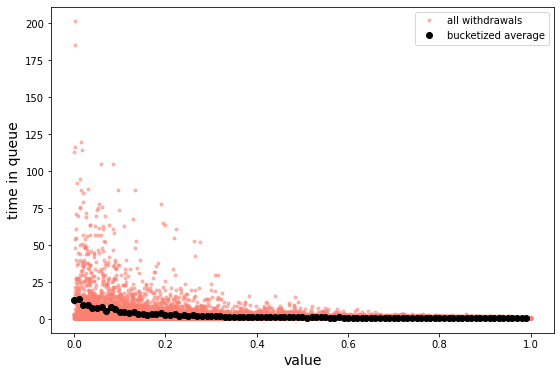

In [383]:
f, ax = plt.subplots(figsize=(9,6))

df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()

ax.plot(results[:,0], results[:,1], 
        linestyle="none", marker='.', color='salmon', alpha=0.5, label='all withdrawals')
ax.plot([b.left for b in reduced['buckets'].values], reduced['avgs'],
        linestyle="none", marker='o', color='black', alpha=1, label='bucketized average')

ax.set_xlabel('value', size=14)
ax.set_ylabel('time in queue', size=14)
ax.legend()
plt.show()

In [103]:
pending = [Pending(value=0, reqTime=2), Pending(value=1, reqTime=2)]
history = [Processed(value=0, procTime=0),Processed(value=0, procTime=1),Processed(value=1, procTime=1)]

for curTime in range(3,20):
    # Expire oldest withdrawals
    historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]
    history = historyNew

    slacks = []
    for c in constraints:
        delta_i, t_i = c
        relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
        slack_i = delta_i - len(relevant_history)
        slacks.append(slack_i)
    minSlack = min(slacks)
    print(minSlack)

    # Process withdrawals
    withdrawals = pending[:minSlack]
    history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])
    pending = pending[minSlack:]

    # Add new pendings
    numWdraws = 2
    newValues = [i for i in range(numWdraws)]
    newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
    pending.extend(newPending)

1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


In [111]:
pending = [Pending(value=0, reqTime=2), Pending(value=1, reqTime=2)]
history = [Processed(value=0, procTime=0),Processed(value=0, procTime=1),Processed(value=1, procTime=1)]
results = []
curTime = 3

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=0, procTime=0', 'proc: value=0, procTime=1', 'proc: value=1, procTime=1']
['proc: value=0, procTime=1', 'proc: value=1, procTime=1']
1
['p: value=0, reqTime=2']
['proc: value=0, procTime=1', 'proc: value=1, procTime=1', 'proc: value=0, procTime=3']
['p: value=1, reqTime=2']
[(0, 1)]
['p: value=1, reqTime=2', 'p: value=0, reqTime=3', 'p: value=1, reqTime=3']


In [112]:
curTime = 4

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=0, procTime=1', 'proc: value=1, procTime=1', 'proc: value=0, procTime=3']
['proc: value=0, procTime=3']
2
['p: value=1, reqTime=2', 'p: value=0, reqTime=3']
['proc: value=0, procTime=3', 'proc: value=1, procTime=4', 'proc: value=0, procTime=4']
['p: value=1, reqTime=3']
[(0, 1), (1, 2), (0, 1)]
['p: value=1, reqTime=3', 'p: value=0, reqTime=4', 'p: value=1, reqTime=4']


In [113]:
curTime = 5

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=0, procTime=3', 'proc: value=1, procTime=4', 'proc: value=0, procTime=4']
['proc: value=0, procTime=3', 'proc: value=1, procTime=4', 'proc: value=0, procTime=4']
0
[]
['proc: value=0, procTime=3', 'proc: value=1, procTime=4', 'proc: value=0, procTime=4']
['p: value=1, reqTime=3', 'p: value=0, reqTime=4', 'p: value=1, reqTime=4']
[(0, 1), (1, 2), (0, 1)]
['p: value=1, reqTime=3', 'p: value=0, reqTime=4', 'p: value=1, reqTime=4', 'p: value=0, reqTime=5', 'p: value=1, reqTime=5']


In [114]:
curTime = 6

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=0, procTime=3', 'proc: value=1, procTime=4', 'proc: value=0, procTime=4']
['proc: value=1, procTime=4', 'proc: value=0, procTime=4']
1
['p: value=1, reqTime=3']
['proc: value=1, procTime=4', 'proc: value=0, procTime=4', 'proc: value=1, procTime=6']
['p: value=0, reqTime=4', 'p: value=1, reqTime=4', 'p: value=0, reqTime=5', 'p: value=1, reqTime=5']
[(0, 1), (1, 2), (0, 1), (1, 3)]
['p: value=0, reqTime=4', 'p: value=1, reqTime=4', 'p: value=0, reqTime=5', 'p: value=1, reqTime=5', 'p: value=0, reqTime=6', 'p: value=1, reqTime=6']


In [115]:
curTime = 7

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=1, procTime=4', 'proc: value=0, procTime=4', 'proc: value=1, procTime=6']
['proc: value=1, procTime=6']
2
['p: value=0, reqTime=4', 'p: value=1, reqTime=4']
['proc: value=1, procTime=6', 'proc: value=0, procTime=7', 'proc: value=1, procTime=7']
['p: value=0, reqTime=5', 'p: value=1, reqTime=5', 'p: value=0, reqTime=6', 'p: value=1, reqTime=6']
[(0, 1), (1, 2), (0, 1), (1, 3), (0, 3), (1, 3)]
['p: value=0, reqTime=5', 'p: value=1, reqTime=5', 'p: value=0, reqTime=6', 'p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7']


In [116]:
curTime = 8

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=1, procTime=6', 'proc: value=0, procTime=7', 'proc: value=1, procTime=7']
['proc: value=1, procTime=6', 'proc: value=0, procTime=7', 'proc: value=1, procTime=7']
0
[]
['proc: value=1, procTime=6', 'proc: value=0, procTime=7', 'proc: value=1, procTime=7']
['p: value=0, reqTime=5', 'p: value=1, reqTime=5', 'p: value=0, reqTime=6', 'p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7']
[(0, 1), (1, 2), (0, 1), (1, 3), (0, 3), (1, 3)]
['p: value=0, reqTime=5', 'p: value=1, reqTime=5', 'p: value=0, reqTime=6', 'p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8']


In [117]:
curTime = 9

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=1, procTime=6', 'proc: value=0, procTime=7', 'proc: value=1, procTime=7']
['proc: value=0, procTime=7', 'proc: value=1, procTime=7']
1
['p: value=0, reqTime=5']
['proc: value=0, procTime=7', 'proc: value=1, procTime=7', 'proc: value=0, procTime=9']
['p: value=1, reqTime=5', 'p: value=0, reqTime=6', 'p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8']
[(0, 1), (1, 2), (0, 1), (1, 3), (0, 3), (1, 3), (0, 4)]
['p: value=1, reqTime=5', 'p: value=0, reqTime=6', 'p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8', 'p: value=0, reqTime=9', 'p: value=1, reqTime=9']


In [118]:
curTime = 10

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=0, procTime=7', 'proc: value=1, procTime=7', 'proc: value=0, procTime=9']
['proc: value=0, procTime=9']
2
['p: value=1, reqTime=5', 'p: value=0, reqTime=6']
['proc: value=0, procTime=9', 'proc: value=1, procTime=10', 'proc: value=0, procTime=10']
['p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8', 'p: value=0, reqTime=9', 'p: value=1, reqTime=9']
[(0, 1), (1, 2), (0, 1), (1, 3), (0, 3), (1, 3), (0, 4), (1, 5), (0, 4)]
['p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8', 'p: value=0, reqTime=9', 'p: value=1, reqTime=9', 'p: value=0, reqTime=10', 'p: value=1, reqTime=10']


In [119]:
curTime = 11

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=0, procTime=9', 'proc: value=1, procTime=10', 'proc: value=0, procTime=10']
['proc: value=0, procTime=9', 'proc: value=1, procTime=10', 'proc: value=0, procTime=10']
0
[]
['proc: value=0, procTime=9', 'proc: value=1, procTime=10', 'proc: value=0, procTime=10']
['p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8', 'p: value=0, reqTime=9', 'p: value=1, reqTime=9', 'p: value=0, reqTime=10', 'p: value=1, reqTime=10']
[(0, 1), (1, 2), (0, 1), (1, 3), (0, 3), (1, 3), (0, 4), (1, 5), (0, 4)]
['p: value=1, reqTime=6', 'p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8', 'p: value=0, reqTime=9', 'p: value=1, reqTime=9', 'p: value=0, reqTime=10', 'p: value=1, reqTime=10', 'p: value=0, reqTime=11', 'p: value=1, reqTime=11']


In [120]:
curTime = 12

# Expire oldest withdrawals
historyNew = [h for h in history if (curTime - h.procTime) < T_MAX]

print([str(h) for h in history])
print([str(h) for h in historyNew])

history = historyNew

slacks = []
for c in constraints:
    delta_i, t_i = c
    relevant_history = [h for h in history if (curTime - h.procTime) < t_i]
    slack_i = delta_i - len(relevant_history)
    slacks.append(slack_i)
minSlack = min(slacks)
print(minSlack)

# Process withdrawals
withdrawals = pending[:minSlack]
history.extend([Processed(value=p.value, procTime=curTime) for p in withdrawals])

print([str(w) for w in withdrawals])
print([str(h) for h in history])

pending = pending[minSlack:]
print([str(p) for p in pending])

newResults = [(w.value, curTime - w.reqTime) for w in withdrawals]
results.extend(newResults)
print(results)

# Add new pendings
numWdraws = 2
newValues = [i for i in range(numWdraws)]
newPending = [Pending(value=vi, reqTime=curTime) for vi in newValues]
pending.extend(newPending)

print([str(p) for p in pending])

['proc: value=0, procTime=9', 'proc: value=1, procTime=10', 'proc: value=0, procTime=10']
['proc: value=1, procTime=10', 'proc: value=0, procTime=10']
1
['p: value=1, reqTime=6']
['proc: value=1, procTime=10', 'proc: value=0, procTime=10', 'proc: value=1, procTime=12']
['p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8', 'p: value=0, reqTime=9', 'p: value=1, reqTime=9', 'p: value=0, reqTime=10', 'p: value=1, reqTime=10', 'p: value=0, reqTime=11', 'p: value=1, reqTime=11']
[(0, 1), (1, 2), (0, 1), (1, 3), (0, 3), (1, 3), (0, 4), (1, 5), (0, 4), (1, 6)]
['p: value=0, reqTime=7', 'p: value=1, reqTime=7', 'p: value=0, reqTime=8', 'p: value=1, reqTime=8', 'p: value=0, reqTime=9', 'p: value=1, reqTime=9', 'p: value=0, reqTime=10', 'p: value=1, reqTime=10', 'p: value=0, reqTime=11', 'p: value=1, reqTime=11', 'p: value=0, reqTime=12', 'p: value=1, reqTime=12']
